In [1442]:
import pandas as pd
import glob
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tmdbsimple as tmdb
from tqdm.notebook import tqdm_notebook
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#Folder path must end with /
FOLDER = "/Users/echo/Documents/0424_Data_Enrichment/Project-3/Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['tmdp_api_results_2019.json',
 'basic1_tmdb_data_2013.csv.gz',
 'tmdp_api_results_2023.json',
 'tmdp_api_results_2015.json',
 '.DS_Store',
 'tmdp_api_results_2014.json',
 'tmdp_api_results_2022.json',
 'tmdp_api_results_2018.json',
 'basic1_tmdb_data_2011.csv.gz',
 'tmdp_api_results_2013.json',
 'basic1_tmdb_data_2015.csv.gz',
 'basic1_tmdb_data_2019.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'basic1_tmdb_data_2023.csv.gz',
 'title.basics.tsv.gz',
 'basic1_tmdb_data_2017.csv.gz',
 'basic1_tmdb_data_2021.csv.gz',
 'title_basics.csv.gz',
 'tmdp_api_results_2012.json',
 'tmdp_api_results_2011.json',
 'tmdp_api_results 2001.json',
 'basic1_tmdb_data_2012.csv.gz',
 'all_movies.csv',
 'title.ratings.tsv.gz',
 'basic1_tmdb_data_2010.csv.gz',
 'title-akas-us-only.csv',
 'tmdp_api_results 2000.json',
 'tmdp_api_results_2010.json',
 'final_tmdb_data_2001.csv.gz',
 '.ipynb_checkpoints',
 'tmdp_api_results_2021.json',
 'basic1_tmdb_data_2022.csv.gz',
 'basic1_tmdb_data_2014.csv.gz',
 'basic1_tmdb_

In [1443]:
#Loading in API keys
with open("/Users/echo/Documents/0424_Data_Enrichment/.secret/tmdb_api.json", "r") as f:    
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()    
tmdb.API_KEY =  login['api-key']

In [1444]:
# Load in the dataframe from project part 1 as basics:
basics = pd.read_csv("/Users/echo/Documents/0424_Data_Enrichment/Project-3/Data/basics_input_part4.csv")
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0068865,movie,Lives of Performers,Lives of Performers,0,2016.0,NaN,90,Drama
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
...,...,...,...,...,...,...,...,...,...
1995,tt0264365,movie,Ancient Warriors,Ancient Warriors,0,2003.0,NaN,99,Action
1996,tt0264395,movie,Basic,Basic,0,2003.0,NaN,98,"Action,Crime,Drama"
1997,tt0264410,movie,Berserker,Berserker,0,2004.0,NaN,84,"Action,Adventure,Fantasy"
1998,tt0264425,movie,Bill's Gun Shop,Bill's Gun Shop,0,2001.0,NaN,93,"Crime,Drama"


In [1445]:
#Creating custom function to pull ratings
def get_movie_with_rating(movie_id):
    #Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    #Save the .info .releases dictionaries
    info = movie.info()
    releases = movie.releases()
    
    #Loop thru countries in releases
    for c in releases["countries"]:
        #if the country abbreviation == US
        if c["iso_3166_1"] == "US":
            #Save a certification key to new column
            info["certification"] = c["certification"]
    return info

In [1446]:
#Example of what info the custom function returns
movie = get_movie_with_rating("tt0378194")
movie.keys()

dict_keys(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'certification'])

# Create Required Lists for the Loop
## Define a list of the Years to Extract from the API

In [1447]:
#Years to use in our dataset
YEARS_TO_GET = range(2010,2024)

## Define an errors list

In [1448]:
#Create empty list to append errors later on 
errors = []

In [1449]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

## Start OUTER loop

In [1450]:
# Start of OUTER loop
#progress bar based on years_to_get. DESC means Description name
for YEAR in tqdm_notebook(YEARS_TO_GET, desc="YEARS", position=0):
    #Defining the JSON file to store results for each year
    JSON_FILE = f"{FOLDER}tmdp_api_results_{YEAR}.json"
    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict to the new json file.
        with open(JSON_FILE, "w") as f:
            json.dump([],f)
    #Saving new year as the current df
#     df = basics.loc[basics["startYear"] == YEAR].copy()
    # saving movie ids to list
    movie_ids = basics["tconst"].copy()
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
    # filter out any ids that are already in the JSON_FILE
    try:
        movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df["imdb_id"])]
        movie_ids_to_get
    except:
        pass
    
    #Get index and movie id from list
    # INNER Loop
    for movie_id in tqdm_notebook(movie_ids,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve then data for the movie id
            temp = get_movie_with_rating(movie_id)
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        except Exception as e:
            errors.append([movie_id, e])

                
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}basic1_tmdb_data_{YEAR}.csv.gz",
                        compression="gzip", index=False)
print(f"- Total errors: {len(errors)}")   

YEARS:   0%|          | 0/14 [00:00<?, ?it/s]

Movies from 2010:   0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Using glob to get a list of files that match a pattern

In [1451]:
#Looking for any files with this pattern and saving to variable
q = "Data/basic1_tmdb_data_20*.csv.gz"
chunked_files = glob.glob(q)
# Showing the first 5
sorted(chunked_files)

['Data/basic1_tmdb_data_2010.csv.gz',
 'Data/basic1_tmdb_data_2011.csv.gz',
 'Data/basic1_tmdb_data_2012.csv.gz',
 'Data/basic1_tmdb_data_2013.csv.gz',
 'Data/basic1_tmdb_data_2014.csv.gz',
 'Data/basic1_tmdb_data_2015.csv.gz',
 'Data/basic1_tmdb_data_2016.csv.gz',
 'Data/basic1_tmdb_data_2017.csv.gz',
 'Data/basic1_tmdb_data_2018.csv.gz',
 'Data/basic1_tmdb_data_2019.csv.gz',
 'Data/basic1_tmdb_data_2020.csv.gz',
 'Data/basic1_tmdb_data_2021.csv.gz',
 'Data/basic1_tmdb_data_2022.csv.gz',
 'Data/basic1_tmdb_data_2023.csv.gz']

In [1452]:
## Loading all files as df and appending to a list
df_list = []
for file in chunked_files:
    print(file)
    temp_df = pd.read_csv(f"{file}")
    df_list.append(temp_df)

# Concatenating the list of dfs into 1 combined
df_combined = pd.concat(df_list)


Data/basic1_tmdb_data_2013.csv.gz
Data/basic1_tmdb_data_2011.csv.gz
Data/basic1_tmdb_data_2015.csv.gz
Data/basic1_tmdb_data_2019.csv.gz
Data/basic1_tmdb_data_2023.csv.gz
Data/basic1_tmdb_data_2017.csv.gz
Data/basic1_tmdb_data_2021.csv.gz
Data/basic1_tmdb_data_2012.csv.gz
Data/basic1_tmdb_data_2010.csv.gz
Data/basic1_tmdb_data_2022.csv.gz
Data/basic1_tmdb_data_2014.csv.gz
Data/basic1_tmdb_data_2018.csv.gz
Data/basic1_tmdb_data_2020.csv.gz
Data/basic1_tmdb_data_2016.csv.gz


In [1453]:
#List comprehension to combine files into 1 df
## Loading and Concatenating the list of dfs with 1 line
df = pd.concat([pd.read_csv(file) for file in chunked_files])
df

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,False,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232,tt0035423,en,Kate & Leopold,...,76019048,118,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,False,6.330,1216,PG-13
1,False,/fw5tsNib4QZBEw18xmebpVe3WZ8.jpg,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",http://poetastros.com/el-tango-del-viudo/,602986,tt0062336,es,El tango del viudo y su espejo deformante,...,0,63,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,The Tango of the Widower and Its Distorting Mi...,False,6.167,6,NaN
2,False,/7kIfosP2TlzZeD4a8b2He9COnwg.jpg,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,124023,tt0068865,en,Lives of Performers,...,0,90,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Lives of Performers,False,5.300,3,NaN
3,False,/wXUcSJG6dqNKgIRgqYqX98UA1wz.jpg,NaN,12000000,"[{'id': 18, 'name': 'Drama'}]",https://www.netflix.com/title/80085566,299782,tt0069049,en,The Other Side of the Wind,...,0,122,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,40 years in the making.,The Other Side of the Wind,False,6.700,185,R
4,False,NaN,NaN,350000,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,29163,tt0088751,en,The Naked Monster,...,0,100,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Naked Monster,False,4.000,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954,False,/8h2eom0Wr1ZY3pmzvWefqS2ATFu.jpg,NaN,0,"[{'id': 28, 'name': 'Action'}]",NaN,5127,tt0264365,en,Ancient Warriors,...,0,93,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Ancient Warriors,False,4.400,5,R
1955,False,/yJtLib6f8a61mO3u59JRmjQ7IOg.jpg,NaN,50000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,10782,tt0264395,en,Basic,...,42792561,98,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Deception is their most deadly weapon.,Basic,False,6.519,929,R
1956,False,/kEI58i7X5EtPFN0xRi76WIysscH.jpg,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,61714,tt0264410,en,Berserker: Hell's Warrior,...,0,84,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"They fight with the zeal of fanatics, immune t...",Berserker: Hell's Warrior,False,3.400,12,NaN
1957,False,NaN,NaN,0,[],NaN,271014,tt0264425,en,Bill's Gun Shop,...,0,0,[],Released,NaN,Bill's Gun Shop,False,0.000,0,NaN


3 Question to Answer:

Q1. Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates? (ANOVA)

Q2. Does the release month have an effect on revenue? (ANOVA)

Q3. Is there a significant difference in revenue between movies that belong to a collection and those that do not? (T-Test Independent)



## Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

1.State your Null Hypothesis and Alternative Hypothesis

   * Null Hypothesis: There is no signifcant difference in revenue between genres.
    
   * Alternative Hypothesis: There is a significant difference revenue between genres.

2.Select the correct test according to the data type and number of samples

   * ANOVA 

3.Test assumptions include:

   *  No significant outliers
   *  Normality
   *  Equal Variance


4.I'll be looking out for the p-value from the .levene variance test to determine whether to use the nonparametric tests (medians), Kruskal-Wallis.


In [1454]:
#Checking the size of the groups
df["certification"].value_counts(dropna=False)

NaN        15563
R           7259
PG-13       3227
PG          1165
NR           662
G            293
NC-17         89
Unrated       14
Name: certification, dtype: int64

In [1455]:
#Dropping unnecessary genres
df = df.drop(df[df["certification"] == "Unrated"].index)
df = df.drop(df[df["certification"] == "NC-17"].index)
df = df.drop(df[df["certification"] == "NR"].index)

In [1456]:
#Dropping NaN values in certification columm
df = df.dropna(subset=["certification"])

In [1457]:
## Create groups dictionary. There are only 4 groups, but this is even more helpful when there are many groups
genre_group = {}
## Loop through all unique categories
for i in df["certification"].unique():
    ## Get series for group and rename
    data = df.loc[df["certification"] == i, "revenue"].copy()
    
    # save into the dictionary
    genre_group[i] = data
genre_group.keys()    

dict_keys(['PG-13', 'R', 'PG', 'G'])

## Testing Assumptions


### Normality Test

In [1458]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in genre_group.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {"n": len(data),
                      "p":p,
                      "test stat":stat}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
PG-13,3087.0,0.000000e+00,1912.925834
R,6914.0,0.000000e+00,7555.132363
PG,1120.0,9.420822e-135,617.212130
G,281.0,4.263729e-26,116.834136


In [1459]:
### checking sig with pandas 
norm_results_df["sig"] = norm_results_df["p"] < .05
norm_results_df

,n,p,test stat,sig
PG-13,3087.0,0.000000e+00,1912.925834,True
R,6914.0,0.000000e+00,7555.132363,True
PG,1120.0,9.420822e-135,617.212130,True
G,281.0,4.263729e-26,116.834136,True


These groups do not have a normal distribution. However, if your group sizes (n) are large enough, we can safely ignore the normality assumption.

### Testing Assumption of Unequal Variance

In [1460]:
# with the * operator 
stats.levene(*genre_group.values())

LeveneResult(statistic=374.2676767736281, pvalue=7.375343321584666e-232)

Levene pvalue < .05, so this is showing it is NOT of equal variance. Meaning that we reject the null hypothesis.

### Checking for Outliers

In [1461]:
## Loop through groups dict
for i, data in genre_group.items():

    ## determine if there are any outliers
    outliers = np.abs(stats.zscore(data)) > 3
    
    ## print a statement about how many outliers for which group name
    print(f"There were {outliers.sum()} outliers in the {i} group.")

    ## Remove the outiers from data and overwrite the sector data in the dict
    data = data.loc[~outliers]
    genre_group[i] = data

There were 89 outliers in the PG-13 group.
There were 130 outliers in the R group.
There were 29 outliers in the PG group.
There were 15 outliers in the G group.


### Kruskal Test

In [1462]:
# Perform Kruskal-Wallis test
h_statistic, p_value = stats.kruskal(*genre_group.values())

print(f"Kruskal Result: statistic={h_statistic}, pvalue={p_value}")
# Interpret the result
print("Revenue significantly differs among the genres.")

Kruskal Result: statistic=1512.2995693364735, pvalue=0.0
Revenue significantly differs among the genres.


## Post-hoc multiple comparison tests

In [1463]:
## save the values of revenue and the labels to the certifications
values = df['revenue']
labels = df['certification']

In [1464]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,-15772750.5325,0.2369,-37335658.0467,5790156.9816,False
G,PG-13,-13419595.4326,0.3173,-33557533.0197,6718342.1545,False
G,R,-94809465.5555,0.0,-114476911.9616,-75142019.1494,True
PG,PG-13,2353155.0999,0.9502,-8920360.0744,13626670.2743,False
PG,R,-79036715.0229,0.0,-89446521.0855,-68626908.9603,True
PG-13,R,-81389870.1229,0.0,-88385698.3124,-74394041.9334,True


**Comparison between G and PG:**

* Mean Difference: -15,772,750.53
* p-adj (adjusted p-value): 0.2369
* Conclusion: The p-value is greater than the significance level (commonly set at 0.05), suggesting that there is no statistically significant difference in revenue between G and PG-rated movies.

**Comparison between G and PG-13:**

* Mean Difference: -13,419,595.43
* p-adj: 0.3173
* Conclusion: Similar to the G vs. PG comparison, the p-value is greater than 0.05, indicating no statistically significant difference in revenue between G and PG-13-rated movies.

**Comparison between G and R:**

* Mean Difference: -94,809,465.56
* p-adj: 0.0
* Conclusion: The p-value is less than 0.05, suggesting a statistically significant difference in revenue between G and R-rated movies. The "reject" column indicates that the null hypothesis (no difference) is rejected.

**Comparison between PG and PG-13:**

* Mean Difference: 2,353,155.10
* p-adj: 0.9502
* Conclusion: The high p-value indicates no statistically significant difference in revenue between PG and PG-13-rated movies.

**Comparison between PG and R:**

* Mean Difference: -79,036,715.02
* p-adj: 0.0
* Conclusion: A statistically significant difference in revenue exists between PG and R-rated movies, as indicated by the p-value less than 0.05.

**Comparison between PG-13 and R:**

* Mean Difference: -81,389,870.12
* p-adj: 0.0
* Conclusion: The p-value is less than 0.05, indicating a statistically significant difference in revenue between PG-13 and R-rated movies.


Statistically, there is a significant difference in revenue between G and R-rated movies, and the negative mean difference implies that, on average, G-rated movies have higher revenue than R-rated movies.Therefore, I reject the null hypothesis and choose the alternative hypothesis: There is a significant difference revenue between genres.


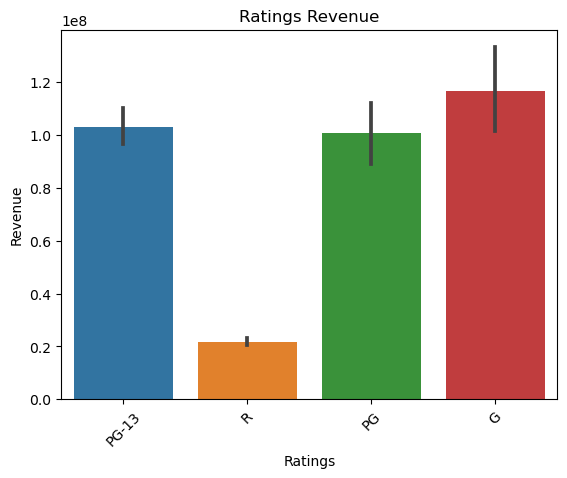

In [1465]:
# Create a box plot comparing revenue to genere
sns.barplot(data=df, x=df['certification'], y=df['revenue'])
plt.xlabel('Ratings')
plt.ylabel('Revenue')
plt.title('Ratings Revenue')
plt.xticks(rotation=45)
plt.show()

# Does the release month have an effect on revenue?

1.State your Null Hypothesis and Alternative Hypothesis

   * Null Hypothesis: The month a movie is released has no signifcant difference in revenue.
    
   * Alternative Hypothesis: The month a movie is released has a signifcant difference in revenue.

2.Select the correct test according to the data type and number of samples

   * ANOVA 

3.Test assumptions include:

   *  No significant outliers
   *  Normality
   *  Equal Variance

4.I'll be looking out for the p-value from the .levene variance test to determine whether to use the nonparametric tests (medians), Kruskal-Wallis.


In [1466]:
#Looking at the dates
df["release_date"]

0       2001-12-25
3       2018-11-02
12      1996-01-01
13      1996-07-04
15      2001-09-21
           ...    
1948    2003-03-21
1950    2005-05-12
1954    2003-03-01
1955    2003-04-18
1958    2002-12-24
Name: release_date, Length: 11402, dtype: object

In [1467]:
#Splitting the dates into different columns
df[["release_year", "release_month", "release_day"]] = df["release_date"].str.split("-", expand=True)
df.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,status,tagline,title,video,vote_average,vote_count,certification,release_year,release_month,release_day
0,False,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232,tt0035423,en,Kate & Leopold,...,Released,"If they lived in the same century, they'd be p...",Kate & Leopold,False,6.330,1216,PG-13,2001,12,25
3,False,/wXUcSJG6dqNKgIRgqYqX98UA1wz.jpg,NaN,12000000,"[{'id': 18, 'name': 'Drama'}]",https://www.netflix.com/title/80085566,299782,tt0069049,en,The Other Side of the Wind,...,Released,40 years in the making.,The Other Side of the Wind,False,6.700,185,R,2018,11,02
12,False,/rFpHBidSlhjflmnLu7BZilyKeQR.jpg,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,73549,tt0116916,en,The Dark Mist,...,Released,NaN,The Dark Mist,False,3.500,2,PG,1996,01,01
13,False,NaN,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,492619,tt0116991,en,Mariette in Ecstasy,...,Released,NaN,Mariette in Ecstasy,False,0.000,0,PG-13,1996,07,04
15,False,/9NZAirJahVilTiDNCHLFcdkwkiy.jpg,NaN,22000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696,tt0118589,en,Glitter,...,Released,"In music she found her dream, her love, herself.",Glitter,False,4.438,129,PG-13,2001,09,21


In [1468]:
#Dropping column we no longer need
df = df.drop(columns="release_date")

In [1469]:
df["release_month"].value_counts()

09    1313
01    1275
03    1066
10    1054
04    1047
08     966
02     953
05     879
06     842
11     697
12     691
07     619
Name: release_month, dtype: int64

In [1470]:
## Create groups dictionary. 
date_group = {}
## Loop through all unique categories
for i in df["release_month"].unique():
    ## Get series for group and rename
    data = df.loc[df["release_month"] == i, "revenue"].copy()
    
    # save into the dictionary
    date_group[i] = data
date_group.keys()    

dict_keys(['12', '11', '01', '07', '09', '03', '04', '08', '06', '02', '05', '10'])

## Testing Assumptions


### Normality Test

In [1471]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in date_group.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {"n": len(data),
                      "p":p,
                      "test stat":stat}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
12,691.0,3.672014e-69,315.155262
11,697.0,1.636019e-105,482.558337
01,1275.0,4.507748e-244,1120.649930
07,619.0,2.662720e-19,85.539537
09,1313.0,4.117784e-162,743.206940
03,1066.0,5.112528e-93,425.017439
04,1047.0,2.329247e-147,675.268927
08,966.0,8.279523e-136,622.075575
06,842.0,5.647068e-30,134.692833
02,953.0,3.179462e-135,619.384551


In [1472]:
### checking sig with pandas 
norm_results_df["sig"] = norm_results_df["p"] < .05
norm_results_df

,n,p,test stat,sig
12,691.0,3.672014e-69,315.155262,True
11,697.0,1.636019e-105,482.558337,True
01,1275.0,4.507748e-244,1120.649930,True
07,619.0,2.662720e-19,85.539537,True
09,1313.0,4.117784e-162,743.206940,True
03,1066.0,5.112528e-93,425.017439,True
04,1047.0,2.329247e-147,675.268927,True
08,966.0,8.279523e-136,622.075575,True
06,842.0,5.647068e-30,134.692833,True
02,953.0,3.179462e-135,619.384551,True


These groups do not have a normal distribution. However, "If your group sizes (n) are large enough, we can safely ignore the normality assumption."

### Testing Assumption of Unequal Variance

In [1473]:
# with the * operator 
stats.levene(*date_group.values())

LeveneResult(statistic=178.29437380569112, pvalue=0.0)

Levene pvalue < .05, so this is showing it is NOT of equal variance. Meaning that we reject the null hypothesis.

### Checking for Outliers

In [1474]:
## Loop through groups dict
for i, data in date_group.items():

    ## determine if there are any outliers
    outliers = np.abs(stats.zscore(data)) > 3
    
    ## print a statement about how many outliers for which group name
    print(f"There were {outliers.sum()} outliers in the {i} month.")

    ## Remove the outiers from data and overwrite the sector data in the dict
    data = data.loc[~outliers]
    genre_group[i] = data

There were 15 outliers in the 12 month.
There were 14 outliers in the 11 month.
There were 42 outliers in the 01 month.
There were 0 outliers in the 07 month.
There were 29 outliers in the 09 month.
There were 29 outliers in the 03 month.
There were 29 outliers in the 04 month.
There were 27 outliers in the 08 month.
There were 0 outliers in the 06 month.
There were 29 outliers in the 02 month.
There were 0 outliers in the 05 month.
There were 30 outliers in the 10 month.


In [1475]:
# Perform Kruskal-Wallis test
h_statistic, p_value = stats.kruskal(*date_group.values())

print(f"Kruskal Result: statistic={h_statistic}, pvalue={p_value}")
# Interpret the result
print("The month significantly differs among the revenue.")

Kruskal Result: statistic=952.7042463034255, pvalue=2.8763029768397243e-197
The month significantly differs among the revenue.


## Post-hoc multiple comparison tests

In [1476]:
## save the values of revenue and the labels to the certifications
values = df['revenue']
labels = df['release_month']

In [1477]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
01,02,26690806.6802,0.0,9575430.5362,43806182.8242,True
01,03,17118181.2711,0.036,530052.0585,33706310.4836,True
01,04,15247193.0324,0.1115,-1422709.9388,31917096.0037,False
01,05,146377975.9316,0.0,128855167.3381,163900784.525,True
01,06,65734598.6664,0.0,47985361.669,83483835.6639,True
01,07,103393523.8702,0.0,83813195.6299,122973852.1105,True
01,08,12829973.3803,0.3658,-4219370.4897,29879317.2502,False
01,09,5485234.8294,0.9928,-10230152.0928,21200621.7516,False
01,10,7105505.8958,0.9646,-9533973.8709,23744985.6625,False
01,11,70973673.1769,0.0,52145318.47,89802027.8838,True


The test shows that there is a significant difference in the results with the R-rated genre.  The revenue was significantly higher for those R-rated movies.

Therefore, I reject the null hypothesis and choose the alternative hypothesis: There is a significant difference revenue between genres.

In [1478]:
## Post-hoc multiple comparison tests

## save the values of revenu and the labels to the certifications
values = df['revenue']
labels = df['release_month']

## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
01,02,26690806.6802,0.0,9575430.5362,43806182.8242,True
01,03,17118181.2711,0.036,530052.0585,33706310.4836,True
01,04,15247193.0324,0.1115,-1422709.9388,31917096.0037,False
01,05,146377975.9316,0.0,128855167.3381,163900784.525,True
01,06,65734598.6664,0.0,47985361.669,83483835.6639,True
01,07,103393523.8702,0.0,83813195.6299,122973852.1105,True
01,08,12829973.3803,0.3658,-4219370.4897,29879317.2502,False
01,09,5485234.8294,0.9928,-10230152.0928,21200621.7516,False
01,10,7105505.8958,0.9646,-9533973.8709,23744985.6625,False
01,11,70973673.1769,0.0,52145318.47,89802027.8838,True


Based on the Tukey results, we reject the null hypothesis and accept the alternative hypothesis: The month a movie is released has a signifcant difference in revenue.

The following months have statistically significant differences in mean revenue compared to other months:

* Month 01 (January)
* Month 02 (February)
* Month 03 (March)
* Month 05 (May)
* Month 06 (June)
* Month 07 (July)
* Month 09 (September)
* Month 11 (November)
* Month 12 (December)

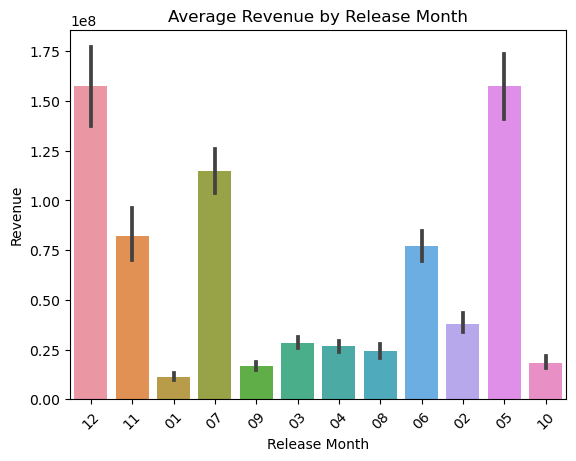

In [1479]:
# Create a box plot
sns.barplot(data=df, x=df['release_month'], y=df['revenue'])
plt.xlabel('Release Month')
plt.ylabel('Revenue')
plt.title('Average Revenue by Release Month')
plt.xticks(rotation=45)
plt.show()

# Q3. Is there a significant difference in revenue between movies that belong to a collection and those that do not?

1.State your Null Hypothesis and Alternative Hypothesis

Null Hypothesis: There is no signifcant difference in revenue between movies that belong to a collection and those that do not.

Alternative Hypothesis: There is a significant difference in revenue between movies that belong to a collection and those that do not.

2.Select the correct test according to the data type and number of samples

T-Test Independent

3.Test assumptions include:

* No significant outliers
* Normality
* Equal Variance

4.Execute the selected test, or the alternative test (if you do not meet the assumptions)

I'll be looking out for the p-value from the .levene variance test to determine whether to use the add`equal_var=False` to `ttest_ind`.

5.Interpret your p-value and reject or fail to reject your null hypothesis

6.Show a supporting visualization that helps display the result

In [1480]:
# Splitting up data between movies with dictionaries and movies with NaN values
in_a_collection = df_combined[df_combined["belongs_to_collection"].notna()].copy()
not_in_collection = df_combined[df_combined["belongs_to_collection"].isna()].copy()

# Display the results
in_a_collection.head()  # DataFrame containing movies with dictionaries
not_in_collection.head()  # DataFrame containing movies with NaN values

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,False,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232,tt0035423,en,Kate & Leopold,...,76019048,118,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,False,6.330,1216,PG-13
1,False,/fw5tsNib4QZBEw18xmebpVe3WZ8.jpg,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",http://poetastros.com/el-tango-del-viudo/,602986,tt0062336,es,El tango del viudo y su espejo deformante,...,0,63,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,The Tango of the Widower and Its Distorting Mi...,False,6.167,6,NaN
2,False,/7kIfosP2TlzZeD4a8b2He9COnwg.jpg,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,124023,tt0068865,en,Lives of Performers,...,0,90,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Lives of Performers,False,5.300,3,NaN
3,False,/wXUcSJG6dqNKgIRgqYqX98UA1wz.jpg,NaN,12000000,"[{'id': 18, 'name': 'Drama'}]",https://www.netflix.com/title/80085566,299782,tt0069049,en,The Other Side of the Wind,...,0,122,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,40 years in the making.,The Other Side of the Wind,False,6.700,185,R
4,False,NaN,NaN,350000,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,29163,tt0088751,en,The Naked Monster,...,0,100,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Naked Monster,False,4.000,6,NaN


In [1481]:
collection_presence.value_counts(dropna=False)

False    25610
True      2662
dtype: int64

In [1482]:
#Define our feature of interest
collection_revenue = in_a_collection["revenue"]
no_collection_revenue = not_in_collection["revenue"]
no_collection_revenue

0       76019048
1              0
2              0
3              0
4              0
          ...   
1953           0
1954           0
1955    42792561
1956           0
1957           0
Name: revenue, Length: 25610, dtype: int64

## Check for and remove outliers

In [1483]:
# Check for outliers in charges for non-smoker group
zscores = stats.zscore(collection_revenue)
outliers = abs(zscores)>3
np.sum(outliers)

103

In [1484]:
# remove outliers from non-smoker group
collection_outliers = collection_revenue[(np.abs(stats.zscore(collection_revenue)) < 3)]

In [1485]:
# Check for outliers in charges for smoker group
zscores = stats.zscore(no_collection_revenue)
outliers = abs(zscores)>3
np.sum(outliers)

554

In [1486]:
# remove outliers from smoker group
no_collection_outliers = no_collection_revenue[(np.abs(stats.zscore(no_collection_revenue)) < 3)]

## Check for Normality



In [1487]:
#Checking for normality in non-smokers
stats.normaltest(no_collection_revenue)

NormaltestResult(statistic=28722.01105830366, pvalue=0.0)

pvalue for movies not in a collection is < .05, meaning that it is not normal distribution

In [1488]:
#checking for normalitiy in smokers
stats.normaltest(collection_revenue)


NormaltestResult(statistic=1073.649950501311, pvalue=7.242283157653237e-234)

pvalue for movies belonging to a collection is < .05, meaning that it is not normal distribution.  However, our sample size is large enough to proceed without satisfying this test.  For an independent t-test, sample sizes of 15 per group are considered sufficient.

## Check for Equal Variance

In [1489]:
# Test for equal variance
stats.levene(collection_revenue, no_collection_revenue)


LeveneResult(statistic=7829.326665675177, pvalue=0.0)

Movies in a collection vs. movies not in a collection doesnt have equal variance (pvalue > .05) but I will use `equal_var = False` when we perform our t-test.

## Perform and evaluate the t-test

In [1490]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(collection_revenue, no_collection_revenue, equal_var = False)
result

Ttest_indResult(statistic=31.662729722754765, pvalue=3.4976087476240914e-187)

The p-value < .05, so i reject the null hypothesis and support the alternative hypothesis: There is a significant difference in revenue between movies that belong to a collection and those that do not.

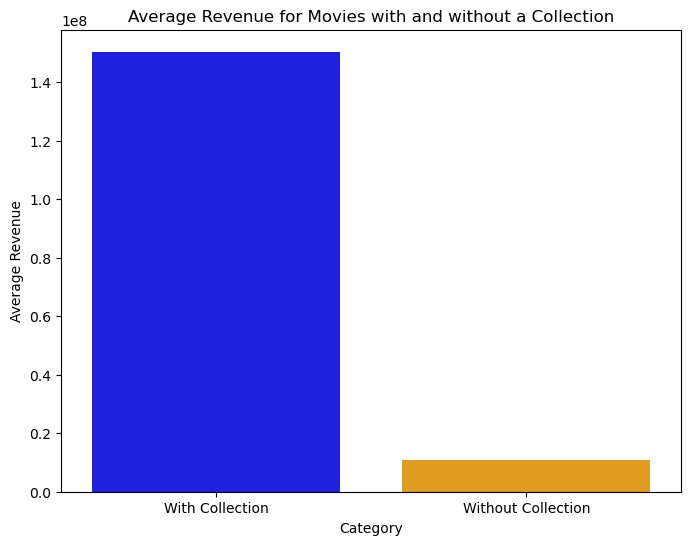

In [1491]:
# Create a dataframe to store the data
data = {'Category': ['With Collection', 'Without Collection'],
        'Average Revenue': [collection_revenue.mean(), no_collection_revenue.mean()]}

# Convert the data into a dataframe
df_collection = pd.DataFrame(data)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=df_collection,x='Category', y='Average Revenue',  palette=['blue', 'orange'])
plt.ylabel('Average Revenue')
plt.title('Average Revenue for Movies with and without a Collection')
plt.show();